# Assignment 5: Extended Long Short-Term Memory (xLSTM)

*Author:* Philipp Seidl

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment, we will explore the xLSTM architecture, a novel extension of the classic LSTM model. The paper can be found here: https://arxiv.org/abs/2405.04517

## Background
Recurrent Neural Networks (RNNs), particularly LSTMs, have proven highly effective in various sequence modeling tasks. However, the emergence of Transformers, with their parallel processing capabilities, has shifted the focus away from LSTMs, especially in large-scale language modeling.
The xLSTM architecture aims to bridge this gap by enhancing LSTMs with mechanisms inspired by modern LLMs (e.g. block-strucutre, residual connections, ...).  Further it introduces:
- Exponential gating with normalization and stabilization techniques, which improves gradient flow and memory capacity.
- Modifications to the LSTM memory structure, resulting in two variants:
    - sLSTM: Employs a scalar memory with a scalar update rule and a new memory mixing technique through recurrent connections.
    - mLSTM: Features a matrix memory, employs a covariance update rule, and is fully parallelizable, making it suitable for scaling.

By integrating these extensions into residual block backbones, xLSTM blocks are formed, which can then be residually stacked to create complete xLSTM architectures.

## Exercise 1: Environment Setup

When working with new architectures or specialized frameworks, it's essential to correctly set up the environment to ensure reproducability. This exercise focuses on setting up the environment for working with the `xlstm` repository.

1. Visit and clone the official repository: [https://github.com/NX-AI/xlstm](https://github.com/NX-AI/xlstm).  
2. Set up the environment  
3. Document your setup:  
   - OS, Python version, Environment setup, CUDA version (if applicable), and GPU details.  
   - Note any challenges you faced and how you resolved them. 
4. Submit your setup as a bash script using the IPython `%%bash` magic. Ensure it is reproducible.

Getting mLSTM working only is fine (if you encounter issues with sLSTM cuda kernels)

> **Note**: Depending on your system setup, you may need to adjust the `environment_pt220cu121.yaml` file, such as for the CUDA version. For this assignment, it is recommended to run it on GPUs. If you don't have one, consider using  [Colab](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) or other online resources.

> **Recommendations**: While the repository suggests using `conda`, we recommend using `mamba` or `micromamba` instead (way faster) (except if you are using colab). Learn more about them here: [https://mamba.readthedocs.io/en/latest/index.html](https://mamba.readthedocs.io/en/latest/index.html).

In [15]:
########## SOLUTION BEGIN ##########

# We use conda (or micromamba) to install the required packages. The yaml file is named lstm_environment.yaml. Run the following command to create the environment:
# conda env create -f lstm_environment.yaml

########## YOUR SOLUTION HERE ##########

In [16]:
fine_tune_again = True
retrain = True

In [17]:
# Verify your installation of xLSTM:
from omegaconf import OmegaConf
from dacite import from_dict
from dacite import Config as DaciteConfig
from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig
import os
import math, time, torch, wandb
import torch.nn as nn
from dotenv import load_dotenv

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn.functional as F
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorForLanguageModeling
import datetime
import dotenv
import os

DEVICE = "cuda" if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else "cpu"
print(DEVICE)
load_dotenv()

use_slstm_kernels = False # set to True if you want to check if sLSTM cuda kernels are working

xlstm_cfg = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if use_slstm_kernels else 'vanilla'}
    num_heads: 4
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 64
num_blocks: 7
embedding_dim: 64
slstm_at: [] # empty = mLSTM only
"""
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
xlstm_stack = xLSTMBlockStack(cfg)

x = torch.randn(4, 32, 64).to(DEVICE)
xlstm_stack = xlstm_stack.to(DEVICE)
y = xlstm_stack(x)
y.shape == x.shape

cuda


True

In [18]:
print(xlstm_stack.config)

xLSTMBlockStackConfig(mlstm_block=mLSTMBlockConfig(mlstm=mLSTMLayerConfig(proj_factor=2.0, round_proj_up_dim_up=True, round_proj_up_to_multiple_of=64, _proj_up_dim=128, conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4, embedding_dim=64, bias=False, dropout=0.0, context_length=64, _num_blocks=7, _inner_embedding_dim=128), _num_blocks=7, _block_idx=None), slstm_block=sLSTMBlockConfig(slstm=sLSTMLayerConfig(hidden_size=64, num_heads=4, num_states=4, backend='vanilla', function='slstm', bias_init='powerlaw_blockdependent', recurrent_weight_init='zeros', _block_idx=None, _num_blocks=7, num_gates=4, gradient_recurrent_cut=False, gradient_recurrent_clipval=None, forward_clipval=None, batch_size=8, input_shape='BSGNH', internal_input_shape='SBNGH', output_shape='BNSH', constants={}, dtype='bfloat16', dtype_b='float32', dtype_r='bfloat16', dtype_w='bfloat16', dtype_g='bfloat16', dtype_s='bfloat16', dtype_a='float32', enable_automatic_mixed_precision=True, initial_val=0.0, embedding_dim=6

## Exercise 2: Understanding xLSTM Hyperparameters
Explain key hyperparameters that influence the performance and behavior of the xLSTM architecture and explain how they influence total parameter count.
The explanation should include: proj_factor, num_heads, act_fn, context_length, num_blocks, embedding_dim, hidden_size, dropout, slstm_at, qkv_proj_blocksize, conv1d_kernel_size. Also include how the matrix memory size of mLSTM is determined.

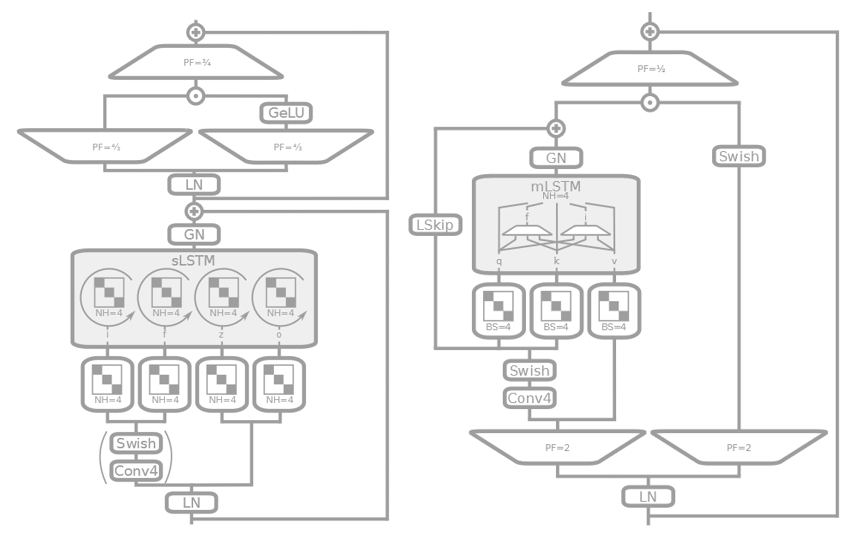

- **Proj_Factor:** Used for up/down projecting layer outputs (4/3 for sLSTM, 1/2 for mLSTM).
- **Num_Heads:** Determines memory mixing in sLSTM (not applicable to mLSTM); block diagonal matrix with *num_heads* blocks.
- **Act_Fn:** Typically uses GeLU activation.
- **Context_Length:** Defines sequence length input, set to 64.
- **Num_Blocks:** Number of mLSTM blocks in a sequence; 7 mLSTM blocks with no sLSTM in the current setup.
- **Embedding_Dim:** Size of token embeddings.
- **Hidden_Size:** Size of the hidden state.
- **Dropout:** Percentage of units randomly deactivated during training.
- **sLSTM_at:** Specifies positions for sLSTM blocks within mLSTM blocks; none used if left empty.
- **qkv_Proj_Blocksize:** Block size for query, key, value matrices in mLSTM.
- **conv1d_kernel_size:** Kernel size used in initial sLSTM and mLSTM layers.
- **Swish:** Activation function defined as $\text{swish}_\beta (x) = \frac{x}{1+e^{-\beta x}}$.
- **LSkip:** Dynamically skips layers using gating.
- **GN:** Group Normalization layer.
- **LN:** Layer normalization applied head-wise.

**Matrix Memory Size of mLSTM:**
- Update rule: $$C_t = C_{t-1} + v_t k_t^\top$$ where $C_t$ is now a matrix ($\mathbb{R}^{d \times d}$), unlike the scalar in normal LSTM.

## Exercise 3: Train an xLSTM model on the Trump Dataset from the previous exercise
Your task is to train an xLSTM model on the Trump Dataset from the previous exercise. 
- The goal is to achieve an average validation loss $\mathcal{L}_{\text{val}} < 1.35$. 
- You do not need to perform an extensive hyperparameter search, but you should document your runs. Log your runs with used hyperparameters using tools like wandb, neptune, mlflow, ... or a similar setup. Log training/validation loss and learning rate over steps as well as total trainable parameters of the model for each run.
- You can use the training setup from the previous exercises or any setup of your choice using high level training libaries.

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [20]:
# Initialize Weights & Biases for hyperparameter tracking
wandb.init(
    project="xLSTM-Trump",
    config={
        "eval_interval": 200,
        "log_interval": 100,
        "eval_iters": 20,
        "batch_size": 8,
        "context_size": 128,
        "hidden_size": 128,
        "learning_rate": 5e-3,
        "max_iters": 2401,
        "weight_decay": 1e-1,
        "beta1": 0.9,
        "beta2": 0.999,
        "grad_clip": 1.0,
        "warmup_iters": 200,
        "min_lr": 5e-4,
        "vocab": 'abcdefghijklmnopqrstuvwxyz0123456789 .!?'
    }
)
wandb_config = wandb.config

In [21]:
class beautifulXLSTM(nn.Module):
    def __init__(self, model_config, hidden_size=128, vocab_size=40, n_layer=4, dropout=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, hidden_size)
        self.blocks = nn.ModuleList([xLSTMBlockStack(model_config) for _ in range(n_layer)])
        self.proj = torch.nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        self.ln = nn.LayerNorm(hidden_size)

    def forward(self, x):
        emb = self.embedding(x)
        x = self.dropout(emb)
        for block in self.blocks:
            x = block(x)
            x = self.ln(x)
        x = self.proj(x + emb)  # residual connection
        return x

In [22]:
# Extract hyperparameters from wandb wandb_config
eval_interval = wandb_config.eval_interval
log_interval = wandb_config.log_interval
eval_iters = wandb_config.eval_iters
batch_size = wandb_config.batch_size
context_size = wandb_config.context_size
hidden_size = wandb_config.hidden_size
learning_rate = wandb_config.learning_rate
max_iters = wandb_config.max_iters
weight_decay = wandb_config.weight_decay
beta1 = wandb_config.beta1
beta2 = wandb_config.beta2
grad_clip = wandb_config.grad_clip
warmup_iters = wandb_config.warmup_iters
min_lr = wandb_config.min_lr

vocab = wandb_config.vocab
vocab_size = len(vocab)

In [23]:
def get_lr(it, learning_rate, warmup_iters, max_iters, min_lr):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > max_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (max_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

def load_data(split):
    import re
    with open(f'trump_{split}.txt', 'r') as f:
        text = f.read()
    text = text.lower()
    text = re.sub('[^a-z0-9 .!?]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = [vocab.index(t) for t in text if t in vocab]
    return torch.tensor(text, dtype=torch.long, device=DEVICE)

def get_batch(split, train_data, val_data, batch_size, context_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_size, (batch_size,), device=device)
    x_positions = ix.unsqueeze(-1) + torch.arange(context_size, device=device)
    y_positions = x_positions + 1
    x = data[x_positions]
    y = data[y_positions]
    return x, y


@torch.no_grad()
def estimate_loss(model, train_data, val_data, eval_iters, batch_size, context_size, vocab_size, device):
    model.eval()
    losses = {"train": 0.0, "val": 0.0}
    for split in ["train", "val"]:
        total_loss = 0.0
        for _ in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, batch_size, context_size, device)
            out = model(X)
            loss = torch.nn.functional.cross_entropy(out.view(-1, vocab_size), Y.view(-1))
            total_loss += loss.item()
        losses[split] = total_loss / eval_iters
    model.train()
    return losses

# Load data
train_data = load_data('train')
val_data = load_data('val')

In [24]:
xlstm_cfg = f"""
  mlstm_block:
    mlstm:
      conv1d_kernel_size: 4
      qkv_proj_blocksize: 4
      num_heads: 4
  slstm_block:
    slstm:
      backend: {'cuda' if use_slstm_kernels else 'vanilla'}
      num_heads: 4
      conv1d_kernel_size: 4
      bias_init: powerlaw_blockdependent
    feedforward:
      proj_factor: 1.3
      act_fn: gelu
  context_length: 128
  num_blocks: 1
  embedding_dim: 128
  slstm_at: [] # empty = mLSTM only
"""
cfg = OmegaConf.create(xlstm_cfg)
model_config = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))

# Initialize model and optimizer
model = beautifulXLSTM(model_config, hidden_size=hidden_size, vocab_size=vocab_size).to(DEVICE)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=wandb_config.learning_rate,
    betas=(wandb_config.beta1, wandb_config.beta2),
    weight_decay=wandb_config.weight_decay
)

In [25]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
wandb.config.update({"total_trainable_parameters": total_params}, allow_val_change=True)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 448840


In [26]:
iter_num = 0
best_val_loss = float('inf')
X, Y = get_batch('train', train_data, val_data, wandb_config.batch_size, wandb_config.context_size, DEVICE)
t0 = time.time()

for iter_num in range(1, wandb_config.max_iters + 1):
    optimizer.zero_grad()
    out = model(X)
    loss = torch.nn.functional.cross_entropy(out.view(-1, vocab_size), Y.view(-1))
    loss.backward()

    if wandb_config.grad_clip > 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), wandb_config.grad_clip)

    optimizer.step()

    # Update learning rate
    lr = get_lr(
        it=iter_num,
        learning_rate=wandb_config.learning_rate,
        warmup_iters=wandb_config.warmup_iters,
        max_iters=wandb_config.max_iters,
        min_lr=wandb_config.min_lr
    )
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Logging training loss and learning rate
    if iter_num % wandb_config.log_interval == 0:
        wandb.log({
            "train_loss": loss.item(),
            "learning_rate": lr,
            "iteration": iter_num
        })
        print(f'[{iter_num}/{wandb_config.max_iters}] loss={loss.item():.4f}, lr={lr:.6f}')

    # Evaluate validation loss at intervals and save the best model
    if iter_num % wandb_config.eval_interval == 0:
        losses = estimate_loss(
            model=model,
            train_data=train_data,
            val_data=val_data,
            eval_iters=wandb_config.eval_iters,
            batch_size=wandb_config.batch_size,
            context_size=wandb_config.context_size,
            vocab_size=vocab_size,
            device=DEVICE
        )
        val_loss = losses["val"]
        wandb.log({
            "val_loss": val_loss,
            "iteration": iter_num
        })
        print(f'[{iter_num}/{wandb_config.max_iters}] val_loss={val_loss:.4f}')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            wandb.save('best_model.pth')

    # Get the next batch
    X, Y = get_batch('train', train_data, val_data, wandb_config.batch_size, wandb_config.context_size, DEVICE)

print(f'Training completed in {time.time() - t0:.2f} seconds. Best validation loss: {best_val_loss:.4f}')

# Finish the wandb run
wandb.finish()

[100/2401] loss=1.9323, lr=0.002500
[200/2401] loss=1.6538, lr=0.005000
[200/2401] val_loss=1.7064
[300/2401] loss=1.4297, lr=0.004977
[400/2401] loss=1.3959, lr=0.004909
[400/2401] val_loss=1.5413
[500/2401] loss=1.2679, lr=0.004797
[600/2401] loss=1.3800, lr=0.004643
[600/2401] val_loss=1.4818
[700/2401] loss=1.3152, lr=0.004451
[800/2401] loss=1.3818, lr=0.004224
[800/2401] val_loss=1.3767
[900/2401] loss=1.1969, lr=0.003967
[1000/2401] loss=1.0084, lr=0.003686
[1000/2401] val_loss=1.3718
[1100/2401] loss=1.1587, lr=0.003385
[1200/2401] loss=1.2267, lr=0.003072
[1200/2401] val_loss=1.3616
[1300/2401] loss=1.4249, lr=0.002752
[1400/2401] loss=1.1043, lr=0.002432
[1400/2401] val_loss=1.3076
[1500/2401] loss=1.1076, lr=0.002118
[1600/2401] loss=1.0586, lr=0.001817
[1600/2401] val_loss=1.2816
[1700/2401] loss=1.0238, lr=0.001535
[1800/2401] loss=1.0832, lr=0.001278
[1800/2401] val_loss=1.2462
[1900/2401] loss=1.0391, lr=0.001051
[2000/2401] loss=1.1013, lr=0.000859
[2000/2401] val_loss=

iteration,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▄████▇▇▇▆▆▅▅▅▄▄▃▃▂▂▂▁▁▁▁
train_loss,█▆▄▄▃▄▃▄▃▁▂▃▄▂▂▁▁▂▁▂▂▂▁▁
val_loss,█▆▅▄▃▃▃▂▂▁▁▂
iteration,2400
learning_rate,0.0005
train_loss,0.99442
val_loss,1.2306


## Exercise 4: Utilizing a Pretrained Model (Bonus)

Foundation Models, those pretrained on large amounts of data are more and more important. We can use those models and fine-tune them on our dataset, rather then training them from scratch.
Here are the things to consider:

- Model Selection: Choose a pretrained language model from an online repository. Hint: You can explore platforms like Hugging Face (huggingface.co), which host numerous pretrained models.

- Dataset: Use the Trump dataset with the same training and validation split as in previous exercises. You do not need to use character tokenization.

- Performance Evaluation: Evaluate the performance of the pretrained model on the validation set before and during fine-tuning. Report average-CE-loss as well as an example generated sequence with the same prompt for each epoch.
 
- Fine-tuning: Adjust the learning rate, potentially freeze some layers, train for a few epochs with a framework of your choice (e.g. [lightning](https://lightning.ai/docs/pytorch/stable/), [huggingface](https://huggingface.co/models), ...)

- Computational Resources: Be mindful of the computational demands of pretrained models. You might need access to GPUs. Try to keep the model size at a minimum and go for e.g. distilled versions or other small LMs

- Hyperparameter Tuning: You can experiment with different learning rates and potentially other hyperparameters during fine-tuning but no need to do this in depth

By completing this exercise, you will gain experience with utilizing pretrained models, understanding their capabilities, and the process of fine-tuning. Decreasing the validation loss can be seen a success for this exercise.

> **Note**: This is a standalone exercise and doesn't build upon the previous tasks.

In [27]:
starting_point = "Make america great again!"

### Model Selection

In [28]:
access_token = os.getenv("ACCESS_TOKEN") # access token with write priveleges, made at https://huggingface.co/settings/tokens/new?tokenType=write

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(DEVICE)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

OutOfMemoryError: CUDA out of memory. Tried to allocate 250.00 MiB. GPU 0 has a total capacity of 5.59 GiB of which 141.81 MiB is free. Including non-PyTorch memory, this process has 4.04 GiB memory in use. Of the allocated memory 3.89 GiB is allocated by PyTorch, and 35.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Test the new model by generating a text

start_time = time.time()
input_ids = tokenizer.encode(starting_point, return_tensors="pt").to("cpu")
output = model.generate(input_ids, max_length=100, do_sample=True, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(output[0], skip_special_tokens=True))
print(f"Generation took {time.time()-start_time} seconds")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Make america great again!
In the world of food, we know that it has to be a good idea to get a good or good idea about the ingredients (or ingredients for our food). We will always make a good food that is good – it's great for us to make a good food that goes from something we will not want to make at home.
What is good at work? So much so (and most importantly for me, it’s so) that I learned
Generation took 2.2632522583007812 seconds


### Dataset

In [ ]:
# Load the datasets from text files
def load_text_data(file_path):
    return load_dataset("text", data_files={"data": file_path})

train_dataset = load_text_data("trump_train.txt")
test_dataset = load_text_data("trump_val.txt")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator for language modeling tasks
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

### Performance Evaluation Pretrained:

In [ ]:
def evaluate_model(trainer, tokenizer, model, eval_dataset):
    """Evaluates the model by generating text and computing validation loss"""
    # Generate text
    input_ids = tokenizer(starting_point, return_tensors="pt").input_ids.to(model.device)
    output = model.generate(input_ids, max_length=50, num_return_sequences=1, do_sample=True)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"Generated text after epoch: {generated_text}")

    # Compute validation loss
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in eval_dataset:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            total_loss += outputs.loss.item()
    avg_loss = total_loss / len(eval_dataset)
    print(f"Validation Loss: {avg_loss}")
    model.train()

### Fine-Tuning

In [ ]:
def freeze_weights(model, freeze_layers):
    """Freezes specific layers of the model"""
    for name, param in model.named_parameters():
        if any(layer in name for layer in freeze_layers):
            param.requires_grad = False

In [ ]:
# Freeze specific layers (example: freezing embedding and first transformer layers)
freeze_layers = ["embed_tokens", "layers.0"] # TODO: Check
freeze_weights(model, freeze_layers)

In [ ]:
from transformers import TrainerCallback

# Define your custom evaluation function (generates text after each evaluation)
def generate_output():
    input_ids = tokenizer(starting_point, return_tensors="pt").input_ids.to(model.device)
    output = model.generate(input_ids, max_length=100, num_return_sequences=1, do_sample=True)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"Generated text after evaluation: {generated_text}")
    return generated_text  # Optionally return text if you need it elsewhere

# Define a custom callback to invoke the text generation on evaluation
class TextGenerationCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, logs=None, **kwargs):
        # This method will be invoked every time the model is evaluated
        print(f"Custom evaluation invoked at step {state.global_step}")
        generate_output()

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch", 
    load_best_model_at_end=True,
    report_to="none",
)

# Define the trainer with the custom callback for text generation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset["data"],
    eval_dataset=test_dataset["data"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[TextGenerationCallback()]  # Add the custom callback here
)

/home/th3lias/workspace/LSTM/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_38169/1447910839.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
if fine_tune_again:
    trainer.train()
    trainer.save_model("./fine_tuned_distilgpt2")
else:
    model = AutoModelForCausalLM.from_pretrained("./fine_tuned_distilgpt2").to(DEVICE)

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 5.59 GiB of which 16.81 MiB is free. Including non-PyTorch memory, this process has 3.36 GiB memory in use. Of the allocated memory 2.93 GiB is allocated by PyTorch, and 331.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)